## 7. Face Recognition with Siamese Neural Network

### 7.1 Library

In [1]:
import numpy as np
import keras
import pandas as pd
import PIL
import cv2

Using TensorFlow backend.


### 7.3 Face Detection and Face Recognition

안면인식은 두 단계로 나눌 수 있다.

 - 얼굴 검출(Face Detection): 이미지 내 얼굴을 탐지하고 분리. 여러 개가 있다면 각각 따로 탐지.
 - 얼굴 인식(Face Recognition): 이미지에서 검출한 얼굴을 신경망에 입력하고 대상이 누구인지 분류. 여러 개가 있다면 반복.

#### 7.3.1 Face Detection

본 실습에서는 웹캠과 파이썬 오픈CV를 사용해 얼굴 검출 프로그램을 만들 것이다. 알고리즘은 다양하며, 대표적으로 당므 방식을 사용한다.

- 하르 기반 다단계 검출(Haar Cascades)
- 고유 얼굴(Eigenface)
- HOG(Histogram of Oriented Gradients)

본 실습에서는 하르 캐스케이즈를 쓴다. 이 알고리즘은 모든 인간이 다음과 같은 특징을 공유한다고 가정한다.

- 이미와 볼보다 눈 근처가 어둡다.
- 눈보다 코 근처가 밝다.

이처럼 밝은 부분과 어두운 부분을 반복하는 패턴을 하르 특징(Haar Feature)라고 한다. 바이올라와 존스(만든 사람)은 6천 개가 넘는 하르 특징을 사용했다.

In [49]:
# 하르 캐스케이즈 분류 모델은 본 서적의 깃에서 가져올 수 있다.

face_cascades = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [50]:
# 이미지를 입력받아 얼굴을 검출하고 경계선을 그리는 함수를 정의하자.

def detect_faces(img, draw_box=True):
    # 이미지를 흑백으로 바꾼다.
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 얼굴을 검출한다.
    faces = face_cascades.detectMultiScale(grayscale_img,
                                           scaleFactor=1.1,
                                           minNeighbors=5,
                                           minSize=(30, 30),
                                           flags=cv2.CASCADE_SCALE_IMAGE)
    face_box, face_coords = None, []
    # 검출한 얼굴 주위에 테두리를 그린다.
    for (x, y, width, height) in faces:
        if draw_box:
            cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 5)
        face_box = img[y:y+height, x:x+width]
        face_coords = [x, y, width, height]
        
    return img, face_box, face_coords

예제 이미지로 테스트 해봅시다. 예제 이미지도 깃에서 가져옵니다.

In [51]:
import os

In [67]:
files = os.listdir('sample_faces')
images = [file for file in files if 'jpg' in file]
for image in images:
    img = cv2.imread('sample_faces/' + image)
    detected_faces, _, _ = detect_faces(img)
    cv2.imwrite('sample_faces/detected_faces/' + image, detected_faces)

TypeError: 'numpy.ndarray' object is not callable

안 굴러간다. 오늘 잘 안굴러가는구만. 원인을 찾아보자.

In [60]:
detect_faces(img) # 함수가 ndarray를 못 받는다. 

TypeError: 'numpy.ndarray' object is not callable

In [64]:
files = os.listdir('sample_faces')
images = [file for file in files if 'jpg' in file]

img = cv2.imread('sample_faces/' + images[1])
# for image in images:
#     img = cv2.imread('sample_faces/' + image)
#     detect_faces, _, _ = detect_faces(img)
#     cv2.imwrite('sample_faces/detected_faces/' + image, detect_faces)

grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 얼굴을 검출한다.
faces = face_cascades.detectMultiScale(grayscale_img,
                                           scaleFactor=1.1,
                                           minNeighbors=5,
                                           minSize=(30, 30),
                                           flags=cv2.CASCADE_SCALE_IMAGE)
face_box, face_coords = None, []
    # 검출한 얼굴 주위에 테두리를 그린다.
for (x, y, width, height) in faces:
    if True:
        cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 5)
    face_box = img[y:y+height, x:x+width]
    face_coords = [x, y, width, height]

cv2.imwrite('sample_faces/detected_faces/' + images[1], images[1])

TypeError: Expected Ptr<cv::UMat> for argument 'img'

In [63]:
images

['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg']

### 7.4 Requirement of Face Recognition

얼굴 인식 기술에는 많은 제약사항이 있다.

- 속도가 매우 빨라야 한다. 
- 확장성이 있어야 한다.
- 적은 데이터로 높은 정확도를 보장해야 한다.

빠르게 학습하고 빠르게 인식해야 하는데, CNN모델은 매우 많은 시간이 든다. 이용자는 불편해죽는다. 마찬가지로 수천 수만명을 학습해야하니 확장성이 뛰어나야 한다. 마지막으로 사진 몇 장만으로 학습해서 높은 정확도를 내야한다. CNN으로는 불가능한 이유다.

### 7.5 One-shot Learning

앞에서 말했듯이 사진 한 장만으로 어떠한 얼굴도 인식하는 방법을 학습할 수 있는 신경망을 만들어야 하는데, 이를 원샷 학습이라고 한다.

이를 구현하기 위해서는 다른 관점에서 접근해야 한다.

**분류 문제가 아닌 입력 이미지 사이의 유사도를 추정하는 문제로 접근해야 한다.**

모델의 동작 과정은 다음과 같다.

1. A의 스마트폰을 누군가 사용하려고 한다. 온보딩 시 저장한 A의 얼굴 이미지를 로드한다.
2. 전면 카메라로 얼굴 이미지를 찍는다. 이는 곧 테스트 이미지가 된다.
3. 신경망은 정답 이미지와 테스트 이미지를 비교해 두 얼굴의 유사도를 출력한다.
4. 신경망이 출력한 유사도가 특정 임계치 이하라면(즉, 두 사진 속 인물이 동일인이 아니라면) 인증을 거부한다. 임계치 이상이라면 인증을 수락한다.

### 7.6 Siamese Neural Network

단순한 유클리드 거리로는 이미지를 인식하기가 힘들다. 그렇기에 우리는 인간을 통해서 아이디어를 얻는다.

인간이 사람의 얼굴을 인식할 때, 얼굴의 특징을 통해서 인식하는 것처럼 모델도 똑같다.

즉, CNN을 통해 추출한 특징을 유클리드 거리로 유사도를 측정하는 하이브리드 방법을 쓰면 된다.

다만 조건이 있다.

- 이미지 두 개를 동시에 입력해야 함
- 이에 따라 CNN 레이어도 두 개가 필요함
- 유사한 얼굴을 특징 공간 내 동일 지점에 매핑해야 하므로, 두 CNN 레이어는 동일한 가중치를 공유해야 함.

이처럼 가중치를 공유한 두 CNN 레이어를 쌍둥이로 생각할 수 있어서, 샴 쌍둥이에서 이름을 따 샴 신경망이라고 부른다.

### 7.7 Contrastive Loss(대조 손실)

분류가 아닌 거리 비교이기 때문에 손실 함수도 다른 종류가 필요하다. 샴 신경망에서는 대조 손실 함수를 사용한다.

수식은 다음과 같다.

 - Y: 두 이미지가 동일한 대상이라면 1, 다른 대상이라면 0
 - D: 신경망이 출력한 벡터 거리
 
 Contrative Loss = Y * D^2 + (1-Y) * max(margin-D, 0), 여기서 margin은 정규화 효과를 주는 상수항

비슷한 얼굴 사이의 거리가 크면 손실을 크게 계산하고, 거리가 작으면 손실도 작게 계산한다.

### 7.8 Face Dataset

In [7]:
# 넘파이 배열 형태로 이미지 파일을 가져올 것이다.

faces_dir = 'att_faces/'

In [8]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

In [9]:
X_train, y_train = [], []
X_test, y_test = [], []

In [10]:
# faces_dir  아래의 하위 디렉터리 목록을 가져온다.
# 각 하위 디렉터리는 대상의 이미지는 담았다.
subfolders = sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])
# 하위 디렉터리 목록을 대상으로 반복문을 실행한다.
# idx를 대상의 ID로 사용한다.
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = load_img(folder+"/"+file, color_mode='grayscale')
        img = img_to_array(img).astype('float32')/255
        img = img.reshape(img.shape[0], img.shape[1], 1)
        if idx < 35:
            X_train.append(img)
            y_train.append(idx)
        else:
            X_test.append(img)
            y_test.append(idx-35)

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

훈련 데이터셋과 테스트 데이터셋을 마련했다. 이미지를 보면서 데이터셋을 확인해보자.

In [36]:
import matplotlib.pyplot as plt

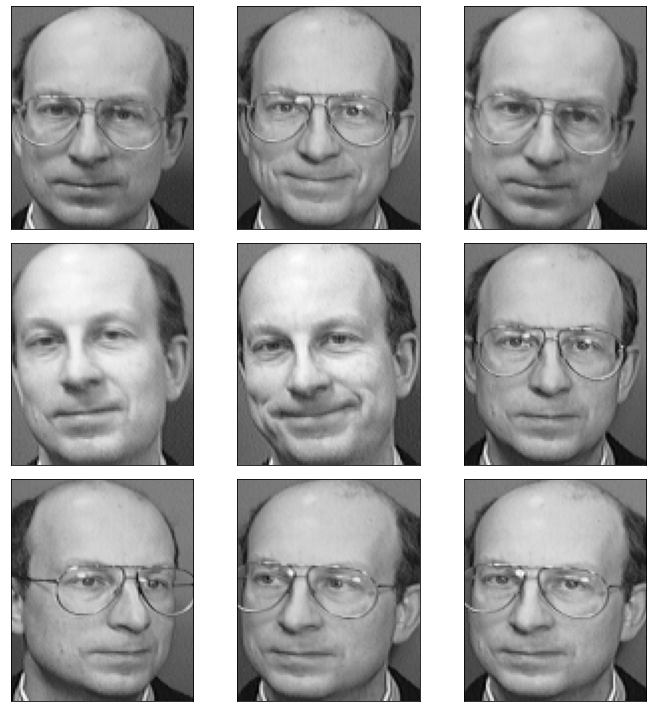

In [13]:
subject_idx = 4
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))
subject_img_idx = np.where(y_train==subject_idx)[0].tolist()
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

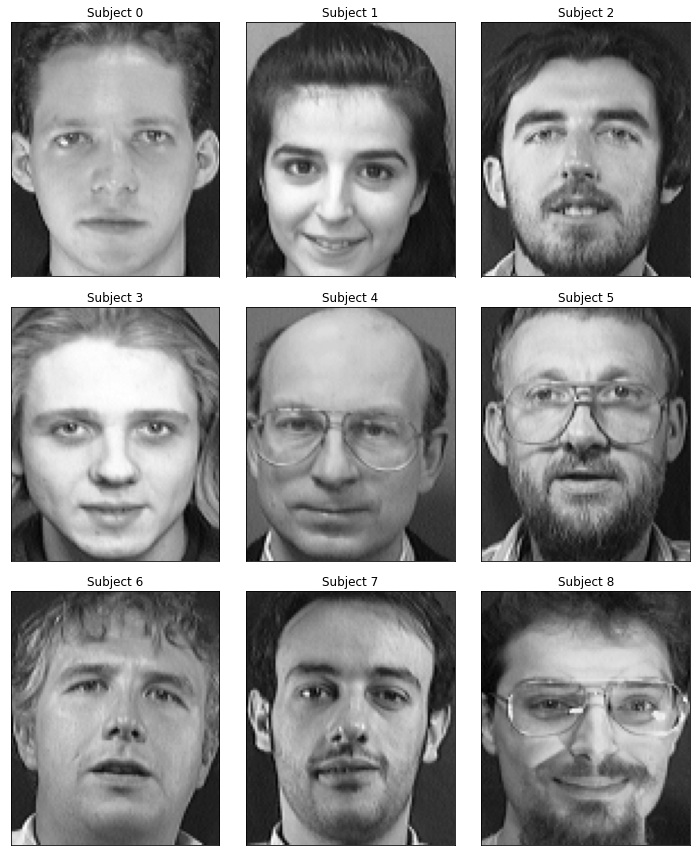

In [14]:
# 첫 아홉 명의 사진을 그린다.

subjects = range(10)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,12))
subject_img_idx = [np.where(y_train==i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Subject {}".format(i))
    
plt.tight_layout()
plt.show()

### 7.9 Siamese Neural Network with Keras

In [15]:
from keras.models import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [16]:
# CNN 모델을 만드는 함수를 만들어두자.

def create_shared_network(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

그렇다면 이 CNN 레이어를 어떻게 복제하고 가중치를 공유하게 만들 수 있을까?

답은 두개를 만들 필요가 없다. 케라스에 이 신경망의 단일 객체만 선언하면 신경망 두 개를 단번에 얻을 수 있다. 단일 객체를 재사용하기 때문에 가중치도 자동으로 공유하게 된다.

In [17]:
# 먼저 신경망을 생성한다.

input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)

In [18]:
# 그런 다음 Input 클래스를 사용해 입력 레이어 두 개를 만든다.

input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

In [19]:
# 이제 케라스의 함수형 메서드를 사용해 각 입력 레이어의 오른쪽에 단일 객체로 만든 신경망을 이어 붙일 수 있다.

output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

이제 두 출력을 하나로 모아 유클리드 거리를 계산해야 한다. 각 출력은 이미지보다 적은 차원의 특징 공간으로, 128 X 1 차원 벡터다.

케라스에는 이런 기능이 없으므로 직접 만들어보자.

In [20]:
from keras import backend as K

In [21]:
# 유클리디안 함수를 만들자.

def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [22]:
# 그런 다음 함수를 Lambda 레이어로 랩핑한다.

from keras.layers import Lambda

In [23]:
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])

In [24]:
# 마지막으로 distance 레이어를 앞서 만든 Input과 결합해 모델을 완성한다.

from keras.models import Model

In [25]:
model = Model(inputs=[input_top, input_bottom], outputs=distance)

In [26]:
# 모델 서머리

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         

### 7.10 Model Fitting

샴 신경망은 일반적인 CNN과 훈련 방법이 다르다.

CNN은 클래스 레이블이 달린 이미지의 배열을 훈련 데이터로 활용하는 반면에,

샴 신경망은 이미지 배열의 쌍을 훈련 데이터셋으로 사용한다.

클래스 레이블도 이미지가 아닌 이미지 쌍별로 필요하며 두 이미지의 동일인 여부를 지정한다.

앞서 7.8절에서 원본 이미지셋을 X_train이라는 넘파이 배열로 로드하고, 클래스 레이블은 y_train 배열에 저장했다.

따라서 X_train, y_train의 데이터로 새로운 이미지 배열 쌍을 생성하는 함수가 필요하다.

이때 각 클래스별 데이터를 균일하게 맞춰야 하므로, 양성 쌍과 음성 쌍을 하나씩 만들어야 한다. 편향이 가지 않게

In [27]:
import random

In [28]:
def create_pairs(X, Y, num_classes):
    pairs, labels = [], []
    # 각 클래스의 이미지를 가리키는 인덱스 배열
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # 이미지가 가장 적은 클래스의 이미지 개수
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
    for c in range(num_classes):
        for n in range(min_images):
            # 양성 쌍을 생성한다.
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
            # 음성 쌍을 생성한다.
            # 현재 클래스 c를 제외한 나머지 클래스 리스트
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # 나머지 클래스 리스트에서 무작위로 하나를 골라 음성 쌍에 사용한다.
            neg_c = random.sample(neg_list, 1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1, img2))
            labels.append(0)
    return np.array(pairs), np.array(labels)

In [33]:
# 함수를 통해 만듭시다.

training_pairs, training_labels = create_pairs(X_train, y_train, len(np.unique(y_train)))
test_pairs, test_labels = create_pairs(X_test, y_test, len(np.unique(y_test)))

이거 함수 다시 이해하게 복기하십쇼.

In [29]:
# 대조 손실 함수도 정의해야 한다.

def contrastive_loss(Y_true, D):
    margin = 1
    loss = K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin-D), 0))
    return loss

# K.mean 은 배열의 평균
# K.square 는 배열의 제곱값
# K.maximum은 배열의 최댓값 케라스 함수다.

In [31]:
model.compile(loss = contrastive_loss, optimizer='adam')

In [34]:
model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels, batch_size=64, epochs=10)

Epoch 1/10
630/630 [==============================] - 43s 68ms/step - loss: 0.2099
Epoch 2/10
630/630 [==============================] - 42s 66ms/step - loss: 0.1094
Epoch 3/10
630/630 [==============================] - 42s 66ms/step - loss: 0.0722
Epoch 4/10
630/630 [==============================] - 43s 68ms/step - loss: 0.0574
Epoch 5/10
630/630 [==============================] - 42s 66ms/step - loss: 0.0446
Epoch 6/10
630/630 [==============================] - 42s 67ms/step - loss: 0.0362
Epoch 7/10
630/630 [==============================] - 45s 72ms/step - loss: 0.0346
Epoch 8/10
630/630 [==============================] - 47s 75ms/step - loss: 0.0284
Epoch 9/10
630/630 [==============================] - 49s 78ms/step - loss: 0.0214
Epoch 10/10
630/630 [==============================] - 45s 71ms/step - loss: 0.0142


### 7.11 Evaluating

In [44]:
idx1, idx2 = 21, 29

def eval_(idx1, idx2):
    img1 = np.expand_dims(X_test[idx1], axis = 0)
    img2 = np.expand_dims(X_test[idx2], axis = 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')

    for ax in [ax1, ax2]:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    dissimilarity = model.predict([img1, img2])[0][0]
    fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=30, color="white")
    plt.tight_layout()
    plt.show()

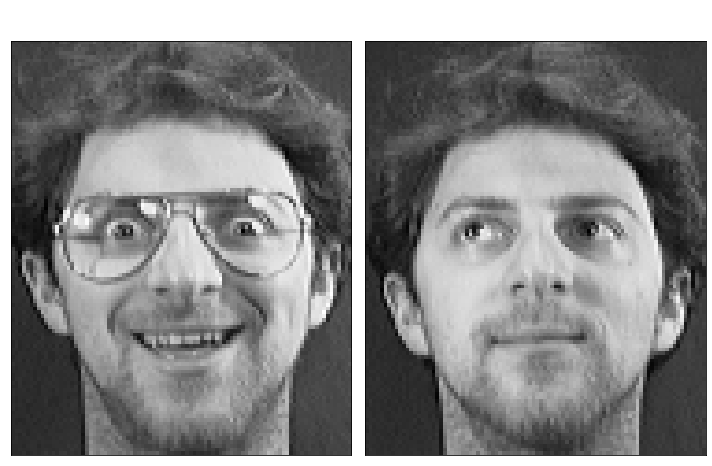

In [45]:
eval_(idx1, idx2)

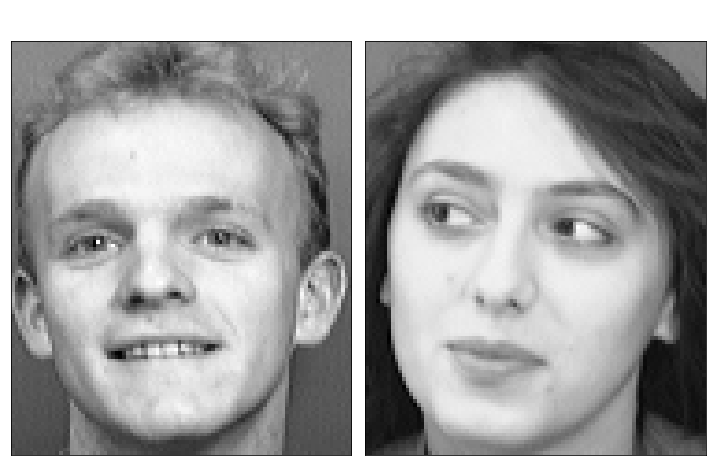

In [46]:
idx3, idx4 = 1, 39
eval_(idx3, idx4)

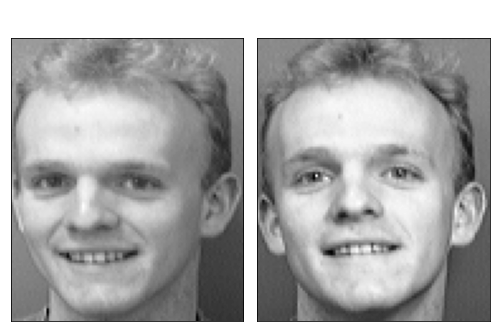

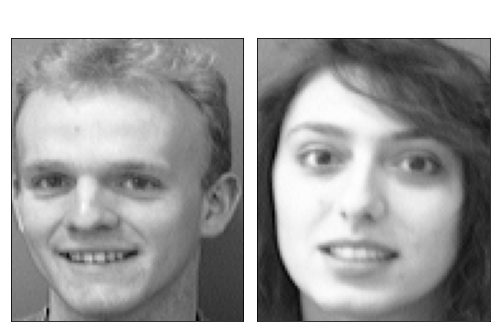

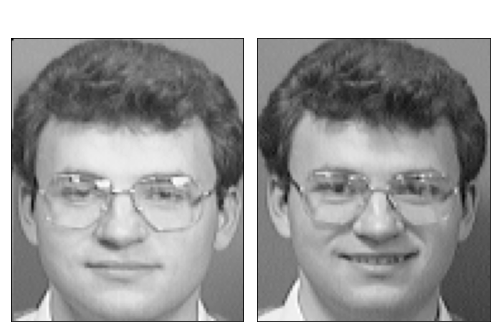

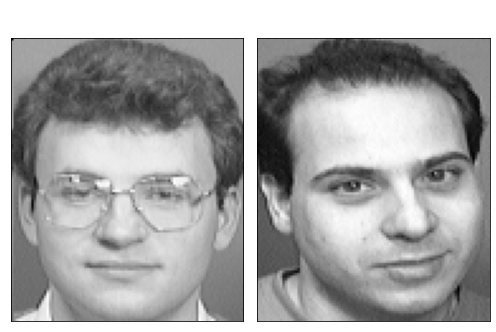

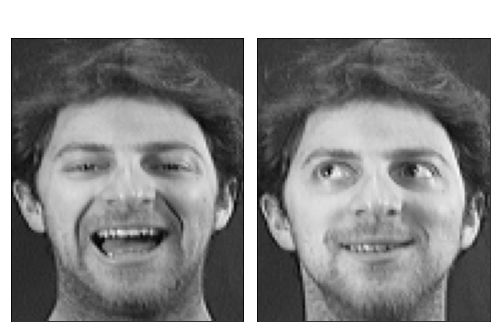

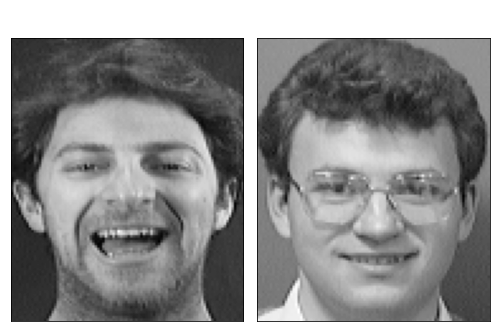

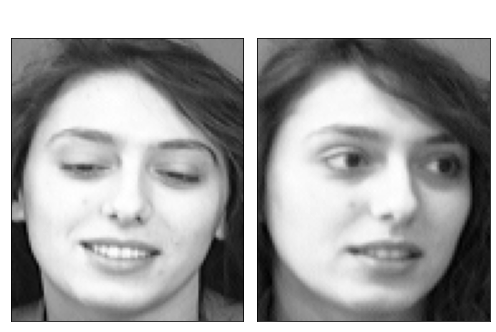

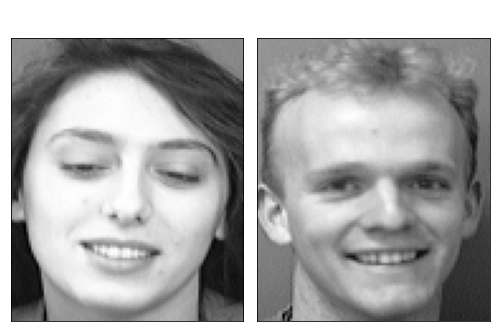

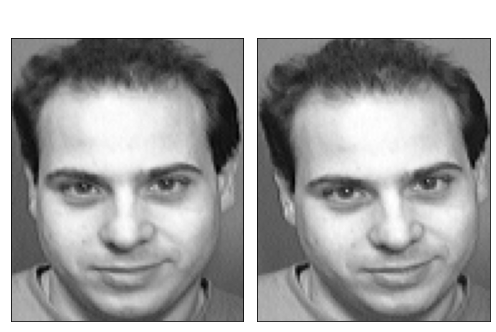

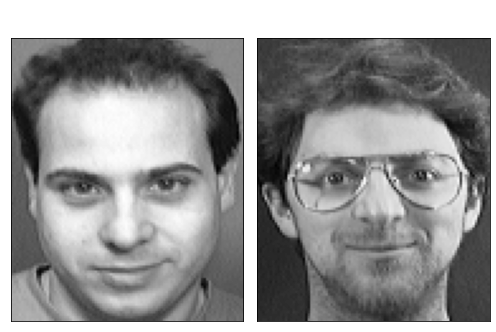

In [47]:
for i in range(5):
    for n in range(0, 2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,5))
        img1 = np.expand_dims(test_pairs[i*20+n, 0], axis=0)
        img2 = np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity = model.predict([img1, img2])[0][0]
        img1, img2 = np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=20, color="white")
plt.show()

### 7.13 Real-time Face Recognition Program

지금까지의 코드를 모아 실시간 안면 인식 프로그램을 만들어 보겠습니다.

1. 안면 인식을 수행하는 샴 신경망을 학습시킨다.
2. 웹캠으로 인증할 사용자의 원본 이미지를 가져와 안면 인식의 온보딩 과정을 수행한다.
3. 이후 사용자를 인증할 때는 1단계에서 훈련시킨 샴 신경망과 2단계에서 습득한 원본 이미지를 사용해 웹캠 이미지와 비교한다.

#### 7.13.1. 온보딩 과정

온보딩 프로그램은 오픈 CV가 제공하는 VideoCapture 함수로 만든다.

In [48]:
import cv2

In [ ]:
video_capture = cv2.VideoCapture(0)